<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Explanation-of-the-different-files" data-toc-modified-id="Explanation-of-the-different-files-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Explanation of the different files</a></span><ul class="toc-item"><li><span><a href="#Input-Files" data-toc-modified-id="Input-Files-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Input Files</a></span></li><li><span><a href="#Output-Files" data-toc-modified-id="Output-Files-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Output Files</a></span></li></ul></li><li><span><a href="#Load-(non-diff)-data" data-toc-modified-id="Load-(non-diff)-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load (non-diff) data</a></span></li><li><span><a href="#Merge-geolocated-+-households" data-toc-modified-id="Merge-geolocated-+-households-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Merge geolocated + households</a></span><ul class="toc-item"><li><span><a href="#Check-that-each-location-has-the-same-#-of-households-for-all-years" data-toc-modified-id="Check-that-each-location-has-the-same-#-of-households-for-all-years-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Check that each location has the same # of households for all years</a></span></li></ul></li><li><span><a href="#Merge-with-original-lsms_labels_agg.csv" data-toc-modified-id="Merge-with-original-lsms_labels_agg.csv-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Merge with original <code>lsms_labels_agg.csv</code></a></span><ul class="toc-item"><li><span><a href="#Compare-index_all-to-index_rep" data-toc-modified-id="Compare-index_all-to-index_rep-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Compare <code>index_all</code> to <code>index_rep</code></a></span></li></ul></li><li><span><a href="#Validate-index-in-lsms_labels_index_of_diffs.csv" data-toc-modified-id="Validate-index-in-lsms_labels_index_of_diffs.csv-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Validate <code>index</code> in <code>lsms_labels_index_of_diffs.csv</code></a></span></li><li><span><a href="#Create-lsmsdelta_pairs.csv" data-toc-modified-id="Create-lsmsdelta_pairs.csv-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Create <code>lsmsdelta_pairs.csv</code></a></span></li></ul></div>

Prerequisites:
1. Run the first couple of sections from `models/baselines_lsms.ipynb` to create `data/lsms_image_hists.npz`

# Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys

import numpy as np
import pandas as pd
import scipy.stats

sys.path.append('../')
from utils.general import load_npz

# Explanation of the different files

## Input Files

`lsms_labels_agg.csv`
- 3020 rows, 1 row = 1 village, corresponds 1-to-1 to the LSMS TFRecords
- "index" column computed as PCA over all LSMS data over the 5 countries (Ethiopia, Malawi, Nigeria, Tanzania, Uganda)
- no information on households count
- "country" column uses country code

`lsms_labels_index_agg_geolocated.csv`
- 2915 rows, 1 row = 1 village
- households that don't appear in more than 1 survey have been filtered out from the wealth index
- includes households count per village
- includes "geolev1" and "geolev2" columns, as well as a wealth index specifically computed for Ethiopia ("et_index")
- includes survey measures (asset ownership questions were binary, quality metrics rated on 5-point scale)

`lsms_labels_index_of_diffs.csv`
- 1540 rows, each row represents a village across 2 surveys
- "index" column: average household difference in wealth index
  - computed by first differencing the wealth index per household, then averaging to the cluster
  - see [Section 6](#Validate-index-in-lsms_labels_index_of_diffs.csv) for how this relates to `lsms_labels_index_agg_geolocated.csv`
- "index_diff" column: principal component of PCA on survey differences
- includes "geolev1" and "geolev2" columns
  - the "geolev2" column here is incorrect; it is actually just a country label

## Output Files

`lsms_wealth_index.csv`
- 3020 rows
- merges:
  - `lsms_labels_agg.csv`
  - `lsms_labels_index_agg_geolocated.csv`
- missing values during merge are left as NaN
- columns: lat/lon, year, country, `ea_id`, `index_all`, `index_rep`, geolev1/2, `n` (# of households), survey variables
  - `index_all` comes from `lsms_labels_agg.csv`
  - `index_rep` comes from `lsms_labels_index_agg_geolocated.csv`

`lsmsdelta_pairs.csv`
- same as `lsms_labels_index_of_diffs.csv` with 2 additional columns `['tfrecords_index.x', 'tfrecords_index.y']` corresponding to indices of the TFRecord files

# Load (non-diff) data

In [3]:
lsms_labels_agg = pd.read_csv('../data/lsms_labels_agg.csv', float_precision='high')
print(lsms_labels_agg.dtypes)
with pd.option_context('display.max_rows', 6):
    display(lsms_labels_agg)

lat        float64
lon        float64
year         int64
country     object
index      float64
ea_id        int64
dtype: object


,lat,lon,year,country,index,ea_id
0,-0.292248,31.478722,2005,ug,0.045405,1110003
1,-0.292248,31.478722,2009,ug,-0.333650,1110003
2,-0.292248,31.478722,2013,ug,-0.386531,1110003
...,...,...,...,...,...,...
3017,9.917938,11.689417,2015,ng,0.119982,590
3018,9.991906,37.692553,2011,et,-1.261734,3061102207
3019,9.991906,37.692553,2015,et,-1.187214,3061102207


In [4]:
lsms_labels_geolocated = pd.read_csv('../data/lsms_labels_index_agg_geolocated.csv', float_precision='high')
geo_hh_df = lsms_labels_geolocated
print(lsms_labels_geolocated.dtypes)
with pd.option_context('display.max_rows', 6):
    display(lsms_labels_geolocated)

country         object
year             int64
lat            float64
lon            float64
index          float64
et_index       float64
n                int64
geolev1         object
geolev2         object
rooms          float64
electric       float64
phone          float64
radio          float64
tv             float64
auto           float64
floor_qual     float64
toilet_qual    float64
watsup_qual    float64
ea_id            int64
dtype: object


,country,year,lat,lon,index,et_index,n,geolev1,geolev2,rooms,electric,phone,radio,tv,auto,floor_qual,toilet_qual,watsup_qual,ea_id
0,ethiopia,2011,3.455701,39.515994,-1.113077,-0.487419,9,ETH.9,ETH.9.6,1.111111,0.0,0.000000,0.333333,0.0,0.0,1.333333,1.333333,3.0,5090302602
1,ethiopia,2011,3.549937,39.184234,-1.153080,-0.509686,2,ETH.9,ETH.9.6,1.000000,0.0,0.000000,0.500000,0.0,0.0,1.000000,1.000000,4.0,5090303404
2,ethiopia,2011,3.864243,39.101366,-1.293889,-0.691564,7,ETH.8,ETH.8.3,1.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,1.000000,4.0,5090302001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,uganda,2013,3.574262,31.132486,-0.784929,NaN,9,UGA.58,UGA.58.1,2.000000,0.0,0.555556,0.111111,0.0,0.0,1.000000,2.111111,3.0,3130001
2913,uganda,2013,3.590473,31.725683,0.294094,NaN,1,UGA.41,UGA.41.2,2.000000,0.0,1.000000,1.000000,0.0,0.0,4.000000,3.000000,3.0,0
2914,uganda,2013,3.692567,31.731667,1.526652,NaN,1,UGA.41,UGA.41.2,3.000000,1.0,1.000000,1.000000,1.0,0.0,4.000000,4.000000,5.0,0


In [5]:
CID_TO_C = {
    'et': 'ethiopia',
    'mw': 'malawi',
    'ng': 'nigeria',
    'tz': 'tanzania',
    'ug': 'uganda',
}

lsms_labels_agg['country'] = lsms_labels_agg['country'].map(lambda cid: CID_TO_C[cid])

## Check that each location has the same # of households for all years

In [6]:
def check_households(df):
    df = df.sort_values('year').reset_index(drop=True)
    n = df['n'].iloc[0]
    return pd.Series({'does_match': np.all(df['n'] == n), 'all': list(df['n']), 'years': list(df['year'])})

matches = geo_hh_df.groupby(['lat', 'lon']).apply(check_households)
display(matches[~matches['does_match']])
bad_matches = matches.loc[~matches['does_match'], 'all'].to_dict()
# np.where(matches == False)

,,does_match,all,years
lat,lon,,,
-0.987177,30.129835,False,"[9, 10, 10]","[2005, 2009, 2013]"
-0.887125,31.711088,False,"[6, 7, 7]","[2005, 2009, 2013]"
-0.867663,30.354115,False,"[8, 9, 9]","[2005, 2009, 2013]"
-0.860807,30.269276,False,"[6, 5, 6]","[2005, 2009, 2013]"
-0.760571,30.179094,False,"[6, 7, 7]","[2005, 2009, 2013]"
-0.576782,31.691637,False,"[7, 8, 8]","[2005, 2009, 2013]"
0.039344,32.540386,False,"[7, 6, 7]","[2005, 2009, 2013]"
0.058414,29.949335,False,"[9, 10, 10]","[2005, 2009, 2013]"
0.071610,32.092873,False,"[10, 9, 10]","[2005, 2009, 2013]"


# Merge with original `lsms_labels_agg.csv`

In [7]:
# "index_all" = index computed over households in all 3020 LSMS villages
# "index_rep" = updated index, with more migrant households removed
lsms_labels_agg.rename({'index': 'index_all'}, axis=1, inplace=True)
geo_hh_df.rename({'index': 'index_rep'}, axis=1, inplace=True)

with pd.option_context('display.max_rows', 6):
    display(lsms_labels_agg)
    display(geo_hh_df)

,lat,lon,year,country,index_all,ea_id
0,-0.292248,31.478722,2005,uganda,0.045405,1110003
1,-0.292248,31.478722,2009,uganda,-0.333650,1110003
2,-0.292248,31.478722,2013,uganda,-0.386531,1110003
...,...,...,...,...,...,...
3017,9.917938,11.689417,2015,nigeria,0.119982,590
3018,9.991906,37.692553,2011,ethiopia,-1.261734,3061102207
3019,9.991906,37.692553,2015,ethiopia,-1.187214,3061102207


,country,year,lat,lon,index_rep,et_index,n,geolev1,geolev2,rooms,electric,phone,radio,tv,auto,floor_qual,toilet_qual,watsup_qual,ea_id
0,ethiopia,2011,3.455701,39.515994,-1.113077,-0.487419,9,ETH.9,ETH.9.6,1.111111,0.0,0.000000,0.333333,0.0,0.0,1.333333,1.333333,3.0,5090302602
1,ethiopia,2011,3.549937,39.184234,-1.153080,-0.509686,2,ETH.9,ETH.9.6,1.000000,0.0,0.000000,0.500000,0.0,0.0,1.000000,1.000000,4.0,5090303404
2,ethiopia,2011,3.864243,39.101366,-1.293889,-0.691564,7,ETH.8,ETH.8.3,1.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,1.000000,4.0,5090302001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,uganda,2013,3.574262,31.132486,-0.784929,NaN,9,UGA.58,UGA.58.1,2.000000,0.0,0.555556,0.111111,0.0,0.0,1.000000,2.111111,3.0,3130001
2913,uganda,2013,3.590473,31.725683,0.294094,NaN,1,UGA.41,UGA.41.2,2.000000,0.0,1.000000,1.000000,0.0,0.0,4.000000,3.000000,3.0,0
2914,uganda,2013,3.692567,31.731667,1.526652,NaN,1,UGA.41,UGA.41.2,3.000000,1.0,1.000000,1.000000,1.0,0.0,4.000000,4.000000,5.0,0


In [8]:
# merge the DataFrames
# assert that the # of villages without household counts
#    is equal to the difference between the two dataframes
cols = ['lat', 'lon', 'year', 'country', 'ea_id']
merged_df = pd.merge(lsms_labels_agg, geo_hh_df, on=cols, how='outer')
assert merged_df['n'].isna().sum() == len(lsms_labels_agg) - len(geo_hh_df)

print('lsms_labels_agg:', len(lsms_labels_agg))
print('geo_hh_df:', len(geo_hh_df))
print('merged_df:', len(merged_df))

for col in cols:
    assert merged_df[col].notna().all()

lsms_labels_agg: 3020
geo_hh_df: 2915
merged_df: 3020


In [9]:
with pd.option_context('display.max_rows', 6):
    display(merged_df)

,lat,lon,year,country,index_all,ea_id,index_rep,et_index,n,geolev1,geolev2,rooms,electric,phone,radio,tv,auto,floor_qual,toilet_qual,watsup_qual
0,-0.292248,31.478722,2005,uganda,0.045405,1110003,0.042136,NaN,8.0,UGA.53,UGA.53.2,4.125000,0.000000,0.125,0.75,0.75,0.0,1.750,3.250000,3.500
1,-0.292248,31.478722,2009,uganda,-0.333650,1110003,-0.326794,NaN,8.0,UGA.53,UGA.53.2,3.000000,0.000000,0.500,0.75,0.00,0.0,1.000,3.750000,3.625
2,-0.292248,31.478722,2013,uganda,-0.386531,1110003,-0.373920,NaN,8.0,UGA.53,UGA.53.2,2.375000,0.000000,0.375,0.75,0.00,0.0,1.375,3.875000,3.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017,9.917938,11.689417,2015,nigeria,0.119982,590,0.017382,NaN,1.0,NGA.16,NGA.16.2,3.000000,1.000000,0.000,1.00,0.00,0.0,2.000,3.000000,4.000
3018,9.991906,37.692553,2011,ethiopia,-1.261734,3061102207,-1.259458,-0.730667,9.0,ETH.3,ETH.3.7,1.666667,0.000000,0.000,0.00,0.00,0.0,1.000,1.000000,3.000
3019,9.991906,37.692553,2015,ethiopia,-1.187214,3061102207,-1.186825,-0.621825,9.0,ETH.3,ETH.3.7,1.777778,0.111111,0.000,0.00,0.00,0.0,1.000,1.111111,3.000


In [10]:
# merged_df.to_csv('../data/lsms_wealth_index.csv', index=False)

## Compare `index_all` to `index_rep`

In [11]:
non_na = merged_df['n'].notna()
r = scipy.stats.pearsonr(merged_df.loc[non_na, 'index_all'], merged_df.loc[non_na, 'index_rep'])
print(r)

(0.9924868824517954, 0.0)


# Validate `index` in `lsms_labels_index_of_diffs.csv`

The difference between the index computed by differencing the `index` column in `lsms_labels_index_agg_geolocated.csv` across years and the `index` column in `lsms_labels_index_of_diffs.csv` comes from:
- `lsms_labels_index_of_diffs.csv` takes the difference between household wealth, then averages this difference in each village. Naturally, households that only show up in one year but not the next are not counted.
- `lsms_labels_index_agg_geolocated.csv` takes the difference between the village-level (averaged) wealth. Thus, households that show up in one year but not the next are still counted.

In [12]:
diffs_df = pd.read_csv('../data/lsms_labels_index_of_diffs.csv', float_precision='high')
print(diffs_df.dtypes)
with pd.option_context('display.max_rows', 6):
    display(diffs_df)

lat           float64
lon           float64
year.x          int64
country        object
year.y          int64
index         float64
index_diff    float64
geolev1        object
geolev2        object
x               int64
dtype: object


,lat,lon,year.x,country,year.y,index,index_diff,geolev1,geolev2,x
0,-0.292248,31.478722,2005,uganda,2009,-0.369128,-1.782208,UGA.53,UGA,8
1,-0.292248,31.478722,2009,uganda,2013,-0.047140,-0.119516,UGA.53,UGA,8
2,-0.439120,31.711950,2005,uganda,2009,-0.211227,-2.585721,UGA.35,UGA,1
...,...,...,...,...,...,...,...,...,...,...
1536,9.912650,42.472549,2011,ethiopia,2015,0.135052,0.456427,ETH.9,ETH,7
1537,9.917938,11.689417,2010,nigeria,2015,0.700611,0.777255,NGA.16,NGA,1
1538,9.991906,37.692553,2011,ethiopia,2015,0.072652,0.049075,ETH.3,ETH,9


In [13]:
def valid_df(df):
    if len(df) == 1:
        return False

    # Uganda: we only calculate deltas for 2005-09 and 2009-13, not 2005-13
    if (2005 in df['year'].values) and (2013 in df['year'].values):
        return 2009 in df['year'].values

    return True

def calc_diffs(df):
    df = df.sort_values(by='year').reset_index(drop=True)
    assert len(df) in [2, 3]
    records = []
    for i in range(len(df)-1):
        lat = df['lat'].iloc[i]
        lon = df['lon'].iloc[i]
        year1 = df['year'].iloc[i]
        year2 = df['year'].iloc[i+1]
        deltaofindex = df['index_rep'].iloc[i+1] - df['index_rep'].iloc[i]
        geolev1 = df['geolev1'].iloc[i]
        households = df['n'].iloc[i]  # use household count from 1st year
        assert int(households) == households
        households = int(households)
        record = [lat, lon, year1, year2, deltaofindex, households, geolev1]
        records.append(record)
    return pd.DataFrame.from_records(records, columns=['lat', 'lon', 'year.x', 'year.y', 'index', 'x', 'geolev1'])

In [14]:
# these are the columns that should be the same
check_cols = ['lat', 'lon', 'year.x', 'year.y', 'index', 'x', 'geolev1']
diffs_df_sorted = diffs_df.sort_values(by=check_cols)[check_cols].reset_index(drop=True)

check_df = (
    geo_hh_df
    .groupby(['lat', 'lon'])
    .filter(valid_df)
    .groupby(['lat', 'lon'])
    .apply(calc_diffs)
    .reset_index(drop=True)
    .sort_values(check_cols))

with pd.option_context('display.max_rows', 6):
    display(check_df)
    display(diffs_df_sorted)

,lat,lon,year.x,year.y,index,x,geolev1
0,-16.985500,35.249901,2010,2016,0.229358,14,MWI.21
1,-16.600000,34.967300,2010,2016,0.282040,16,MWI.3
2,-16.266899,34.895199,2010,2016,0.251074,13,MWI.3
...,...,...,...,...,...,...,...
1536,14.319217,39.271599,2011,2015,0.558964,11,ETH.11
1537,14.353816,37.890876,2011,2015,-0.160779,8,ETH.11
1538,14.455962,39.479082,2011,2015,0.394791,11,ETH.11


,lat,lon,year.x,year.y,index,x,geolev1
0,-16.985500,35.249901,2010,2016,0.229420,14,MWI.21
1,-16.600000,34.967300,2010,2016,0.282046,16,MWI.3
2,-16.266899,34.895199,2010,2016,0.251143,13,MWI.3
...,...,...,...,...,...,...,...
1536,14.319217,39.271599,2011,2015,0.535714,11,ETH.11
1537,14.353816,37.890876,2011,2015,-0.160860,8,ETH.11
1538,14.455962,39.479082,2011,2015,0.394914,11,ETH.11


In [15]:
for col in check_cols:
    if check_df[col].dtype == 'O':  # object type
        assert check_df[col].eq(diffs_df_sorted[col]).all()
    else:
        if not np.array_equal(check_df[col].values, diffs_df_sorted[col].values):
            print(f'{col} not equal')
        if not np.allclose(check_df[col].values, diffs_df_sorted[col].values):
            m = np.max(np.abs(check_df[col].values - diffs_df_sorted[col].values))
            print(f'{col} max abs. difference:', m)

index not equal
index max abs. difference: 0.333339635257925


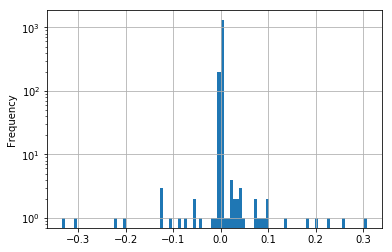

In [16]:
ax = (check_df['index'] - diffs_df_sorted['index']).plot.hist(bins=100)
ax.set_yscale('log')
ax.grid()

In [17]:
r = scipy.stats.pearsonr(check_df['index'], diffs_df_sorted['index'])[0]
print('r^2:', r**2)

r^2: 0.9957775191489074


# Create `lsmsdelta_pairs.csv`

In [18]:
npz = load_npz('../data/lsms_image_hists.npz')
locs = npz['locs']
years = npz['years']

locyear_to_index = {
    (loc[0], loc[1], year): i
    for i, (loc, year) in enumerate(zip(locs, years))
}

image_hists: dtype=int64, shape=(3020, 8, 102)
labels: dtype=float32, shape=(3020,)
locs: dtype=float32, shape=(3020, 2)
years: dtype=int32, shape=(3020,)
nls_center: dtype=float32, shape=(3020,)
nls_mean: dtype=float32, shape=(3020,)


In [19]:
def get_tfrecord_index(series):
    '''
    Args
    - row: pd.Series, entries are (in order) lat, lon, year

    Returns: int, index of TFRecord file
    '''
    lat, lon, year = series
    lat, lon = np.float32((lat, lon))
    year = int(year)
    return locyear_to_index[(lat, lon, year)]

diffs_df['tfrecords_index.x'] = diffs_df[['lat', 'lon', 'year.x']].apply(get_tfrecord_index, axis=1)
diffs_df['tfrecords_index.y'] = diffs_df[['lat', 'lon', 'year.y']].apply(get_tfrecord_index, axis=1)

In [20]:
with pd.option_context('display.max_rows', 6):
    display(diffs_df)

,lat,lon,year.x,country,year.y,index,index_diff,geolev1,geolev2,x,tfrecords_index.x,tfrecords_index.y
0,-0.292248,31.478722,2005,uganda,2009,-0.369128,-1.782208,UGA.53,UGA,8,2574,2694
1,-0.292248,31.478722,2009,uganda,2013,-0.047140,-0.119516,UGA.53,UGA,8,2694,2941
2,-0.439120,31.711950,2005,uganda,2009,-0.211227,-2.585721,UGA.35,UGA,1,2573,2693
...,...,...,...,...,...,...,...,...,...,...,...,...
1536,9.912650,42.472549,2011,ethiopia,2015,0.135052,0.456427,ETH.9,ETH,7,8,337
1537,9.917938,11.689417,2010,nigeria,2015,0.700611,0.777255,NGA.16,NGA,1,1145,1626
1538,9.991906,37.692553,2011,ethiopia,2015,0.072652,0.049075,ETH.3,ETH,9,120,449


In [21]:
# diffs_df.to_csv('../data/lsmsdelta_pairs.csv', index=False)